In [109]:
# Importing libraries and library functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import optuna

In [110]:
# Load the dataset
print("Loading the dataset")
data_path = 'data.csv'  
df = pd.read_csv(data_path)

# check
print(df.info())
print("Data loaded successfully\n")

# Convert statezip to an integer for better processing
df['statezip'] = df['statezip'].apply(lambda x: int(x.split(' ')[1]) if pd.notnull(x) else np.nan)

# Handle missing values: Fill missing values with the median of each numeric column
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Convert date columns to datetime if necessary
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

# Feature Engineering: Add new features or transformations
df['age'] = 2014 - df['yr_built']  # Assuming the dataset is up to date to 2014

# Include all features for the model
features = df.drop(['price'], axis=1).columns

# Handle outliers based on IQR for each numeric feature
for feature in numeric_cols:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR)))]
print("Outliers removed")
    
# Drop non-numeric columns for correlation matrix
df_numeric = df.select_dtypes(include=[np.number])
print("Non-numeric columns dropped for correlation matrix")

Loading the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   o


Displaying correlation matrix


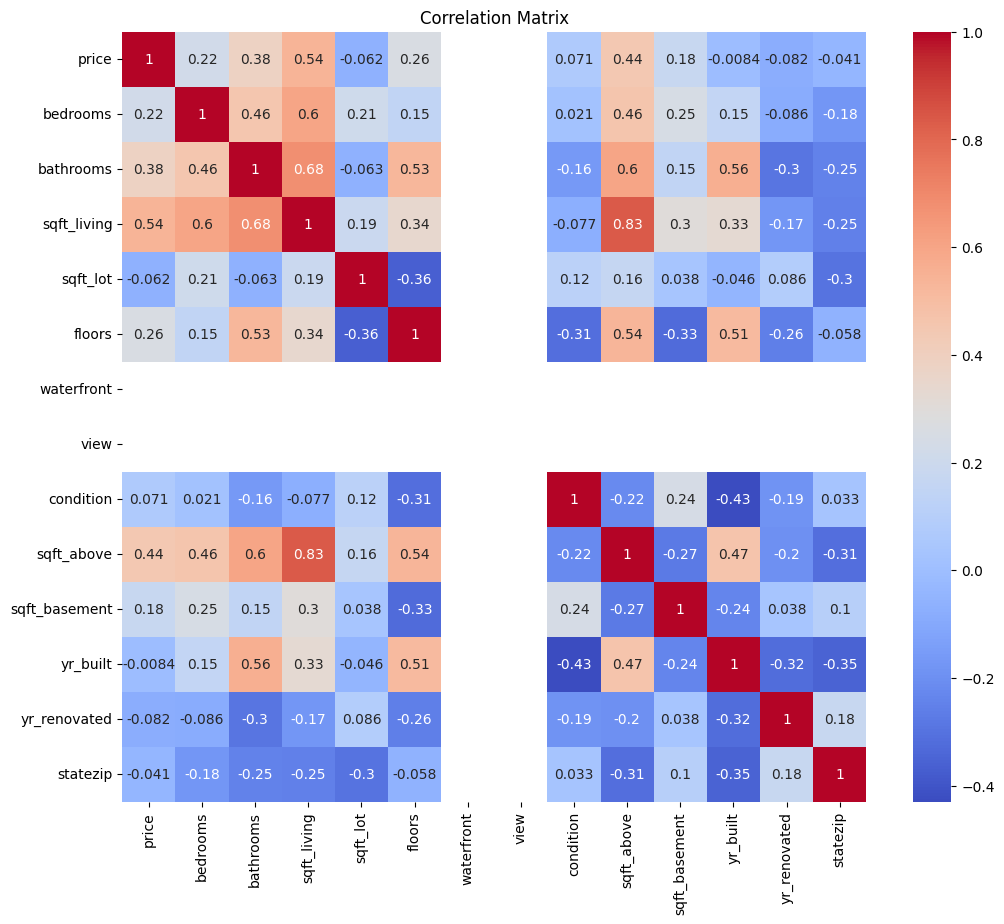

In [111]:
# Display the correlation matrix
print("\nDisplaying correlation matrix")
plt.figure(figsize=(12, 10))
numeric_df = df[numeric_cols] 
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [112]:
# Re-integrate non-numeric columns after outlier removal
df = df.loc[df_numeric.index]
print("Non-numeric columns re-integrated after outlier removal")

# Feature Engineering: Add polynomial features and interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[["sqft_living", "sqft_above", "sqft_basement"]])
poly_feature_names = poly.get_feature_names_out(["sqft_living", "sqft_above", "sqft_basement"])
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
df = pd.concat([df, df_poly], axis=1)

# Define features and target
features = ["bedrooms", "bathrooms", "sqft_living", "floors", "statezip", "waterfront",
            "view", "sqft_above", "sqft_basement", "yr_renovated"] + list(poly_feature_names)
X = df[features]
y = df["price"]

Non-numeric columns re-integrated after outlier removal


In [113]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print("Data split into training and test sets")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled")

Data split into training and test sets
Features scaled


In [114]:
# Train model
model = DecisionTreeRegressor(max_features=15, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print("Model trained & predictions made")

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

# Extract the feature importances
feature_importances = model.feature_importances_

# Select top features
threshold = 0.25
important_features = X.columns[feature_importances > threshold]

X_train_trimmed = X_train[important_features]
X_test_trimmed = X_test[important_features]
X_train_trimmed = scaler.fit_transform(X_train_trimmed)
X_test_trimmed = scaler.transform(X_test_trimmed)


# Retrain model with trimmed features
model.fit(X_train_trimmed, y_train)
y_pred_trimmed = model.predict(X_test_trimmed)
print("\nTrimmed model trained & predictions made")

cv_scores = cross_val_score(model, X_train_trimmed, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

Model trained & predictions made
Cross-Validation Scores: [0.16349728 0.11478465 0.211284   0.23284072 0.24567752]
Mean CV Score: 0.19

Trimmed model trained & predictions made
Cross-Validation Scores: [0.45221267 0.41490003 0.37490287 0.50330578 0.55664032]
Mean CV Score: 0.46


In [115]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [10, 12, 14, 16],
    'min_samples_split': [0.95, 2, 3],
    'min_samples_leaf': [0.9, 0.95, 1],
}

# Perform grid search with range of hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_trimmed, y_train)
print("Best Parameters:", grid_search.best_params_)

# Retrain model
best_params = grid_search.best_params_
model = DecisionTreeRegressor(max_features=15, random_state=42, **best_params)
model.fit(X_train_trimmed, y_train)
y_pred_final = model.predict(X_test_trimmed)
print("\nTuned model (GridSearchCV) trained & predictions made")

cv_scores = cross_val_score(model, X_train_trimmed, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

# Hyperparameter tuning using Optuna
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
    }
    
    model = DecisionTreeRegressor(max_features=15, random_state=42, **param)
    model.fit(X_train_trimmed, y_train)
    y_pred = model.predict(X_test_trimmed)
    r2 = r2_score(y_test, y_pred)
    return r2

# Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("Best Parameters:", study.best_params)


# Retrain model
best_params = study.best_params
model = DecisionTreeRegressor(max_features=15, random_state=42, **best_params)
model.fit(X_train_trimmed, y_train)
y_pred_final = model.predict(X_test_trimmed)
print("\nTuned model (with Optuna) trained & predictions made")

cv_scores = cross_val_score(model, X_train_trimmed, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

[I 2024-05-27 19:10:24,293] A new study created in memory with name: no-name-29f91226-27fc-42d8-bd10-f26b084fdb65
[I 2024-05-27 19:10:24,298] Trial 0 finished with value: 0.6066826187754125 and parameters: {'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.6066826187754125.
[I 2024-05-27 19:10:24,306] Trial 1 finished with value: 0.6256450130238645 and parameters: {'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.6256450130238645.
[I 2024-05-27 19:10:24,312] Trial 2 finished with value: 0.6792461655514908 and parameters: {'max_depth': 16, 'min_samples_split': 17, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6792461655514908.
[I 2024-05-27 19:10:24,317] Trial 3 finished with value: 0.6068635458879927 and parameters: {'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 18}. Best is trial 2 with value: 0.6792461655514908.
[I 2024-05-27 19:10:24,324] Trial 4 finished with value: 

Best Parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 3}

Tuned model (GridSearchCV) trained & predictions made
Cross-Validation Scores: [0.4679438  0.48184771 0.4591924  0.54127616 0.58396312]
Mean CV Score: 0.51
Best Parameters: {'max_depth': 16, 'min_samples_split': 17, 'min_samples_leaf': 8}

Tuned model (with Optuna) trained & predictions made
Cross-Validation Scores: [0.58324029 0.59883846 0.56592553 0.57030059 0.6586466 ]
Mean CV Score: 0.60


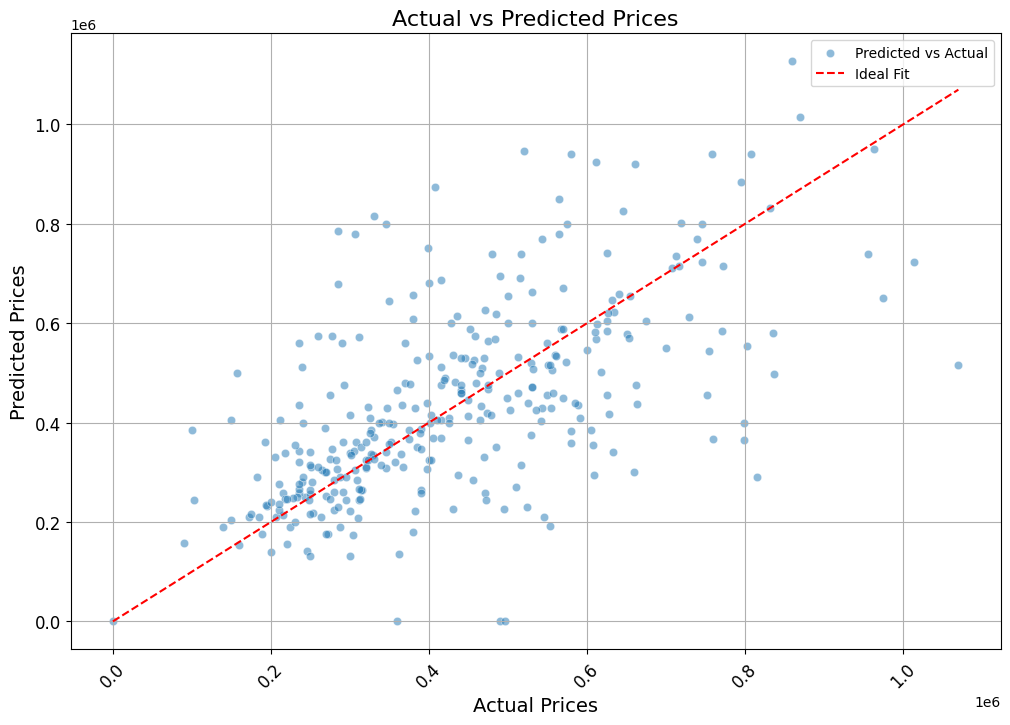

Mean Squared Error: 10649305367.91
R-squared: 0.68

Cross-Validation Scores: [0.58324029 0.59883846 0.56592553 0.57030059 0.6586466 ]
Mean CV Score: 0.60


In [116]:
# Visualize results
plt.figure(figsize=(12, 8))
plt.scatter(
    y_test,
    y_pred,
    alpha=0.5,
    edgecolors="w",
    linewidth=0.5,
    label="Predicted vs Actual",
)
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="red",
    linestyle="--",
    label="Ideal Fit",
)
plt.xlabel("Actual Prices", fontsize=14)
plt.ylabel("Predicted Prices", fontsize=14)
plt.title("Actual vs Predicted Prices", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred_final)
r_squared = r2_score(y_test, y_pred_final)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r_squared:.2f}')

# Cross-Validation
cv_scores = cross_val_score(model, X_train_trimmed, y_train, cv=5)
print(f'\nCross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

In [117]:
# # Gradient Boosting 
# model = GradientBoostingRegressor(n_estimators=895, learning_rate=0.04, max_depth=3, random_state=42)

# # Retrain model
# model.fit(X_train_trimmed, y_train)
# y_pred_gb = model.predict(X_train_trimmed)
# print("Gradient Boosting model trained & predictions made")

# cv_scores = cross_val_score(model, X_train_trimmed, y_train, cv=5)
# print(f'Cross-Validation Scores: {cv_scores}')
# print(f'Mean CV Score: {np.mean(cv_scores):.2f}')


In [119]:
# Zillow's Zestimate Comparison
# Extract the last row of the original DataFrame
last_row = df.iloc[-1:]

# Drop the last row from the original DataFrame for retraining the model
df = df.iloc[:-1]

# Re-define the features and target after dropping the last row
x = df[features]
y = df["price"]

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# Feature scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Train model
model = DecisionTreeRegressor(max_depth=15, random_state=42)
model.fit(x_train_scaled, y_train)

# Scale the features of the last row using the same scaler
last_row_scaled = scaler.transform(last_row[features])

# Predict the price for the last row
predicted_value = model.predict(last_row_scaled)
print(f'\nPredicted price for the last row: ${predicted_value[0]:,.2f}')


Predicted price for the last row: $285,000.00
